# Application of RNN model on multi-frequency sinwave data

In [1]:
## allow interaction with the plots
%matplotlib widget

# add the main directory reference and import 'imports.py'
import sys
sys.path.append('../')
from imports import *

Using: cuda. Device: NVIDIA GeForce GTX TITAN X


Let's create a function that calculates sin wave time series with multiple frequencies

In [2]:
def sin_waves(size=10000, num_osci=100):
    # size: total size of the 1D array
    # num_osci: roughly the number of oscilation in the entire data
    tf = num_osci * np.pi
    t = np.linspace(0., tf, size)
    y = np.sin(2. * t) + 0.5 * np.cos(t) + 2 * np.cos(3*t) + 5 * np.cos(5*t)
    return y.astype(np.float32)

Use the function to create the data

In [3]:
size = 100000
num_osci= 50
MAIN_DATA = sin_waves(size,num_osci)

Let's see what the data looks like

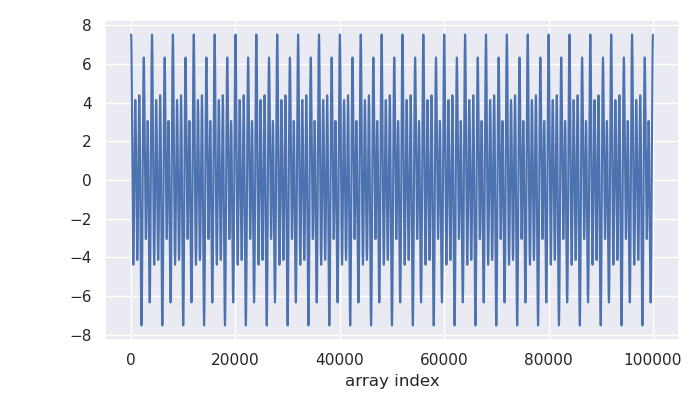

In [4]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_axes([0.15, 0.15, 0.82, 0.8])
ax.plot(MAIN_DATA, '-')
ax.set_xlabel('array index')
plt.show()

We can now use the SeqData class located in 'Utils' folder to create sequenced dataset for training

In [5]:
num_samples = 2000
left_seq_size = 50
right_seq_size = 1 # must be 1 for traditional RNNs
skip_points = 20   # The data above is too high resolution
                   # we can use this paramter to downsample and choose every nth 
                   # data point
noise = 0.0
quiet = False

dataset = SeqData(MAIN_DATA, num_samples, left_seq_size, right_seq_size, skip_points, noise, quiet)
# outputs x, y: [seq, num_samples], [1 or seq, num_samples]


#-------------------------
# Ideally you should provide another time series data to act as validation
# but for this simple example, we can use the same data

val_num_samples = 200
# update validation right_seq_size since during 
# validation we can use even traditional RNN
# to make rolling predictions point-by-point
val_right_seq_size = 100 
val_dataset = SeqData(MAIN_DATA, val_num_samples, left_seq_size, val_right_seq_size, skip_points, noise, quiet)

Main data skip of 20 has been applied!
Data shape changed from 100000 to 4762 after skipping...


Dataset created with 2000 samples. 

Each sample sequence has 50 input len
and 1 target len.

Main data skip of 20 has been applied!
Data shape changed from 100000 to 4762 after skipping...


Dataset created with 200 samples. 

Each sample sequence has 50 input len
and 100 target len.



As a good practice, always look at what you are feeding to the model

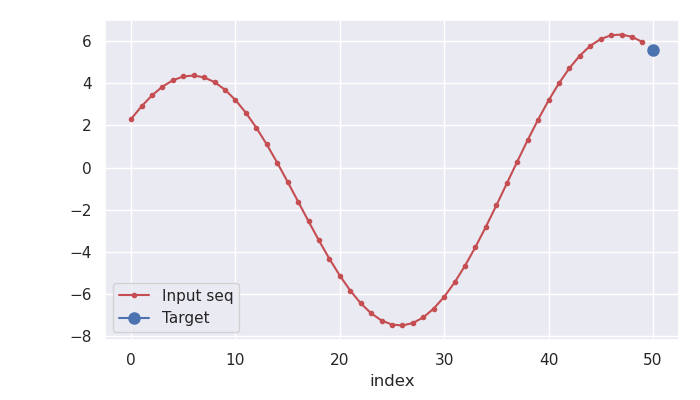

In [6]:
# pick a random index
ran_ind = np.random.randint(0, dataset.x.shape[1])

# NOTE: SeqData outputs in tensors.
# For plotting, we must detach and send to cpu
fig = plt.figure(figsize=(7, 4))
ax = fig.add_axes([0.15, 0.15, 0.82, 0.8])
ax.plot(np.arange(left_seq_size), dataset.x[:,ran_ind].detach().cpu(), '-ro', label='Input seq', ms=3)
ax.plot(left_seq_size+np.arange(right_seq_size), dataset.y[:,ran_ind].detach().cpu(), '-bo', label='Target',ms=8)
ax.set_xlabel('index')
plt.legend()
plt.show()

Let's normalize the data and do train and test splitting

In [7]:
tot_dataset_len = dataset.x.shape[1]
train_size = int(0.9 * tot_dataset_len)
test_size = tot_dataset_len - train_size

norm_fac = torch.max(dataset.x)

Xtrain = dataset.x[:,0:train_size]/norm_fac
Ytrain = dataset.y[:,0:train_size]/norm_fac

Xtest = dataset.x[:,train_size:]/norm_fac
Ytest = dataset.y[:,train_size:]/norm_fac

Xval = val_dataset.x/norm_fac
Yval = val_dataset.y/norm_fac

print(f'Xtrain has {Xtrain.shape[1]} samples and each sample has {Xtrain.shape[0]} points.')
print(f'Ytrain has {Ytrain.shape[1]} samples and each sample has {Ytrain.shape[0]} points.')
print(f'Xtest has {Xtest.shape[1]} samples and each sample has {Xtest.shape[0]} points.')
print(f'Ytest has {Ytest.shape[1]} samples and each sample has {Ytest.shape[0]} points.\n\n')

print('******Validation dataset info********')
print(f'Xval has {Xval.shape[1]} samples and each sample has {Xval.shape[0]} points.')
print(f'Yval has {Yval.shape[1]} samples and each sample has {Yval.shape[0]} points.')

Xtrain has 1800 samples and each sample has 50 points.
Ytrain has 1800 samples and each sample has 1 points.
Xtest has 200 samples and each sample has 50 points.
Ytest has 200 samples and each sample has 1 points.


******Validation dataset info********
Xval has 200 samples and each sample has 50 points.
Yval has 200 samples and each sample has 100 points.


Look at the data once more to make sure things look good

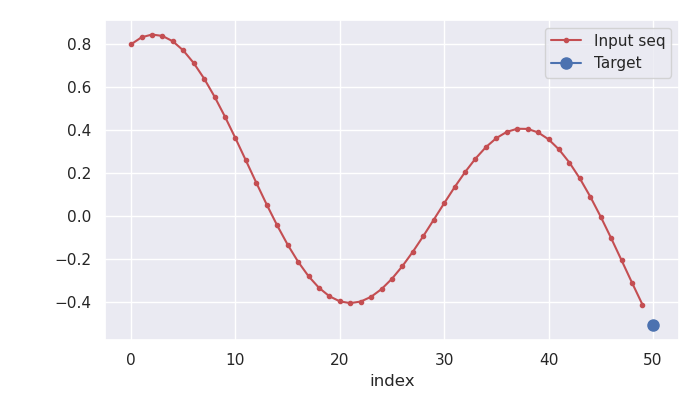

In [8]:
ran_ind = np.random.randint(0, Xtrain.shape[1])
fig = plt.figure(figsize=(7, 4))
ax = fig.add_axes([0.15, 0.15, 0.82, 0.8])
ax.plot(np.arange(left_seq_size), Xtrain[:,ran_ind].cpu(), '-ro', label='Input seq', ms=3)
ax.plot(left_seq_size+np.arange(right_seq_size), Ytrain[:,ran_ind].cpu(), '-bo', label='Target',ms=8)
ax.set_xlabel('index')
plt.legend()
plt.show()

In [10]:
save_path = '../Saved_models'

params = {
'train': True,
'EPOCHS': 200,
'num_layers': 1,
'hidden_size': 50,
'batch_size': 10,
'input_size': 1,
'learning_rate': 0.002,
'flavor': 'lstm',
'left_seq_size': left_seq_size,
'right_seq_size': right_seq_size,
'noise': noise,
'norm_fac': norm_fac,
'save_path': save_path,
'load_previous': True,
'encdec': False, # this notebooks only uses traditional RNN
'test': True,
'val': True, 
'save_model': True,
'iplot': True
}

data = {
    'Xtrain': Xtrain,
    'Ytrain': Ytrain,
    'Xtest': Xtest,
    'Ytest': Ytest,
    'Xval': Xval, 
    'Yval': Yval
}

#--------------------

CT = Create_and_Train(params, data, device)


**************************************************************************
RNN lstm Regression model initialized with 1 layers and 50 hidden size.
I will take in 50 points and predict 1 points
**************************************************************************


Epochs progress [Loss: NA]:   0%|          | 0/200 [00:00<?, ?Epoch/s]

Let's use the trained model to make prediction on one random instance of Xval

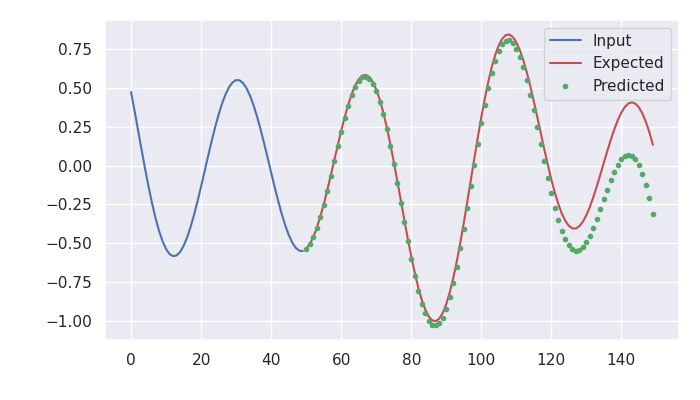

In [11]:
rand_inds=np.random.randint(0, Xval.shape[1], 1)

preds = CT.trainer.RNN_npoint_pred(Xval[:,rand_inds].to(device), val_right_seq_size) 

fig = plt.figure(figsize=(7, 4))
ax = fig.add_axes([0.15, 0.15, 0.82, 0.8])
ax.plot(np.arange(left_seq_size), Xval[:,rand_inds], 'b-', label='Input')
ax.plot(left_seq_size+np.arange(Yval.shape[0]), Yval[:,rand_inds], 'r-', label='Expected')
ax.plot(left_seq_size+np.arange(Yval.shape[0]), preds.cpu(), 'g.', label='Predicted')
plt.legend()
plt.show()


Let's look at the mean square error file generated by the code

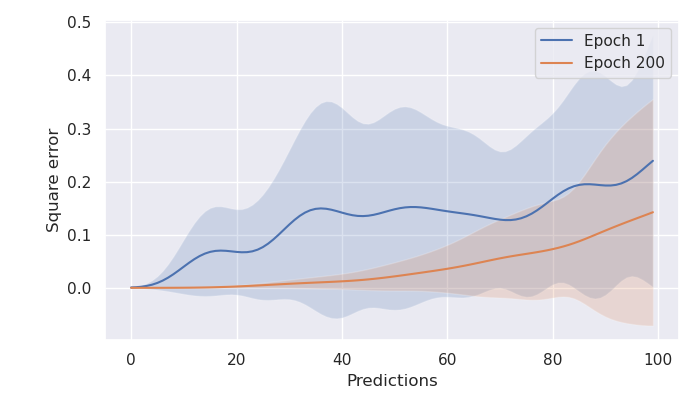

In [12]:
val_errors = np.load(CT.err_filename+'.npz')
val_err_mean = val_errors['mean']
val_err_std = val_errors['std']

# note that the lower bound can becomes -ve 
# depending on the mean and std values
# It will create issue if using log scale on Y axis
upper =  val_err_mean + val_err_std
lower = val_err_mean - val_err_std

fig = plt.figure(figsize=(7, 4))
ax = fig.add_axes([0.15, 0.15, 0.82, 0.8])
for i in [0,val_err_mean.shape[0]-1]: # visualize only first and last epoch
    ax.plot(np.arange(Yval.shape[0]), val_err_mean[i], label=f'Epoch {i+1}')
    ax.fill_between(np.arange(Yval.shape[0]), upper[i], lower[i], alpha=0.2)
ax.set_xlabel('Predictions')
ax.set_ylabel('Square error')
plt.legend()
plt.show()